In [22]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

In [23]:
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, TopRGBSensorConfig
from habitat.config import read_write


In [24]:
from examples.random_walk_sim.parametrized_action import add_param_actions


In [25]:
config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat_baselines.eval.split=train",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat.simulator.habitat_sim_v0.enable_physics=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false",
            # "habitat.environment.iterator_options.num_episode_sample=1",
            # "habitat.environment.iterator_options.shuffle=False"
        ],
        )

In [26]:
with read_write(config):
    agent_config = get_agent_config(sim_config=config.habitat.simulator)
    agent_config.sim_sensors.update(
        {"thirdrgb_sensor": ThirdRGBSensorConfig()}
    )
    agent_config.sim_sensors.update(
        {"toprgb_sensor": TopRGBSensorConfig()}
    )

In [27]:
config = add_param_actions(config)

In [28]:
import json
from omegaconf import OmegaConf
print(json.dumps(OmegaConf.to_container(config), indent=4))

{
    "habitat_baselines": {
        "evaluate": false,
        "trainer_name": "ver",
        "updater_name": "PPO",
        "distrib_updater_name": "DDPPO",
        "torch_gpu_id": 0,
        "tensorboard_dir": "data/training/objectnav/hssd-hab/tb",
        "writer_type": "tb",
        "video_dir": "data/training/objectnav/hssd-hab/video_dir",
        "video_fps": 10,
        "test_episode_count": -1,
        "eval_ckpt_path_dir": "data/training/objectnav/hssd-hab/checkpoints/",
        "num_environments": 24,
        "num_processes": -1,
        "rollout_storage_name": "RolloutStorage",
        "checkpoint_folder": "data/training/objectnav/hssd-hab/checkpoints",
        "num_updates": 270000,
        "num_checkpoints": 500,
        "checkpoint_interval": -1,
        "total_num_steps": -1.0,
        "log_interval": 10,
        "log_file": "train.log",
        "force_blind_policy": false,
        "verbose": true,
        "vector_env_factory": {
            "_target_": "habitat_baselin

In [29]:
env = habitat.Env(config=config)


2024-05-29 11:26:29,202 Initializing dataset ObjectNav-v1
2024-05-29 11:26:44,737 initializing sim Sim-v0
2024-05-29 11:26:47,249 Initializing task ObjectNav-v1


In [30]:
obs = env.reset()

In [31]:
def display_sample(
    rgb_obs
):  # noqa: B006
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    return rgb_img

In [32]:
obs.keys()

dict_keys(['rgb', 'depth', 'third_rgb', 'top_rgb', 'objectgoal', 'compass', 'gps'])

In [33]:
obs['rgb'].shape

(512, 512, 3)

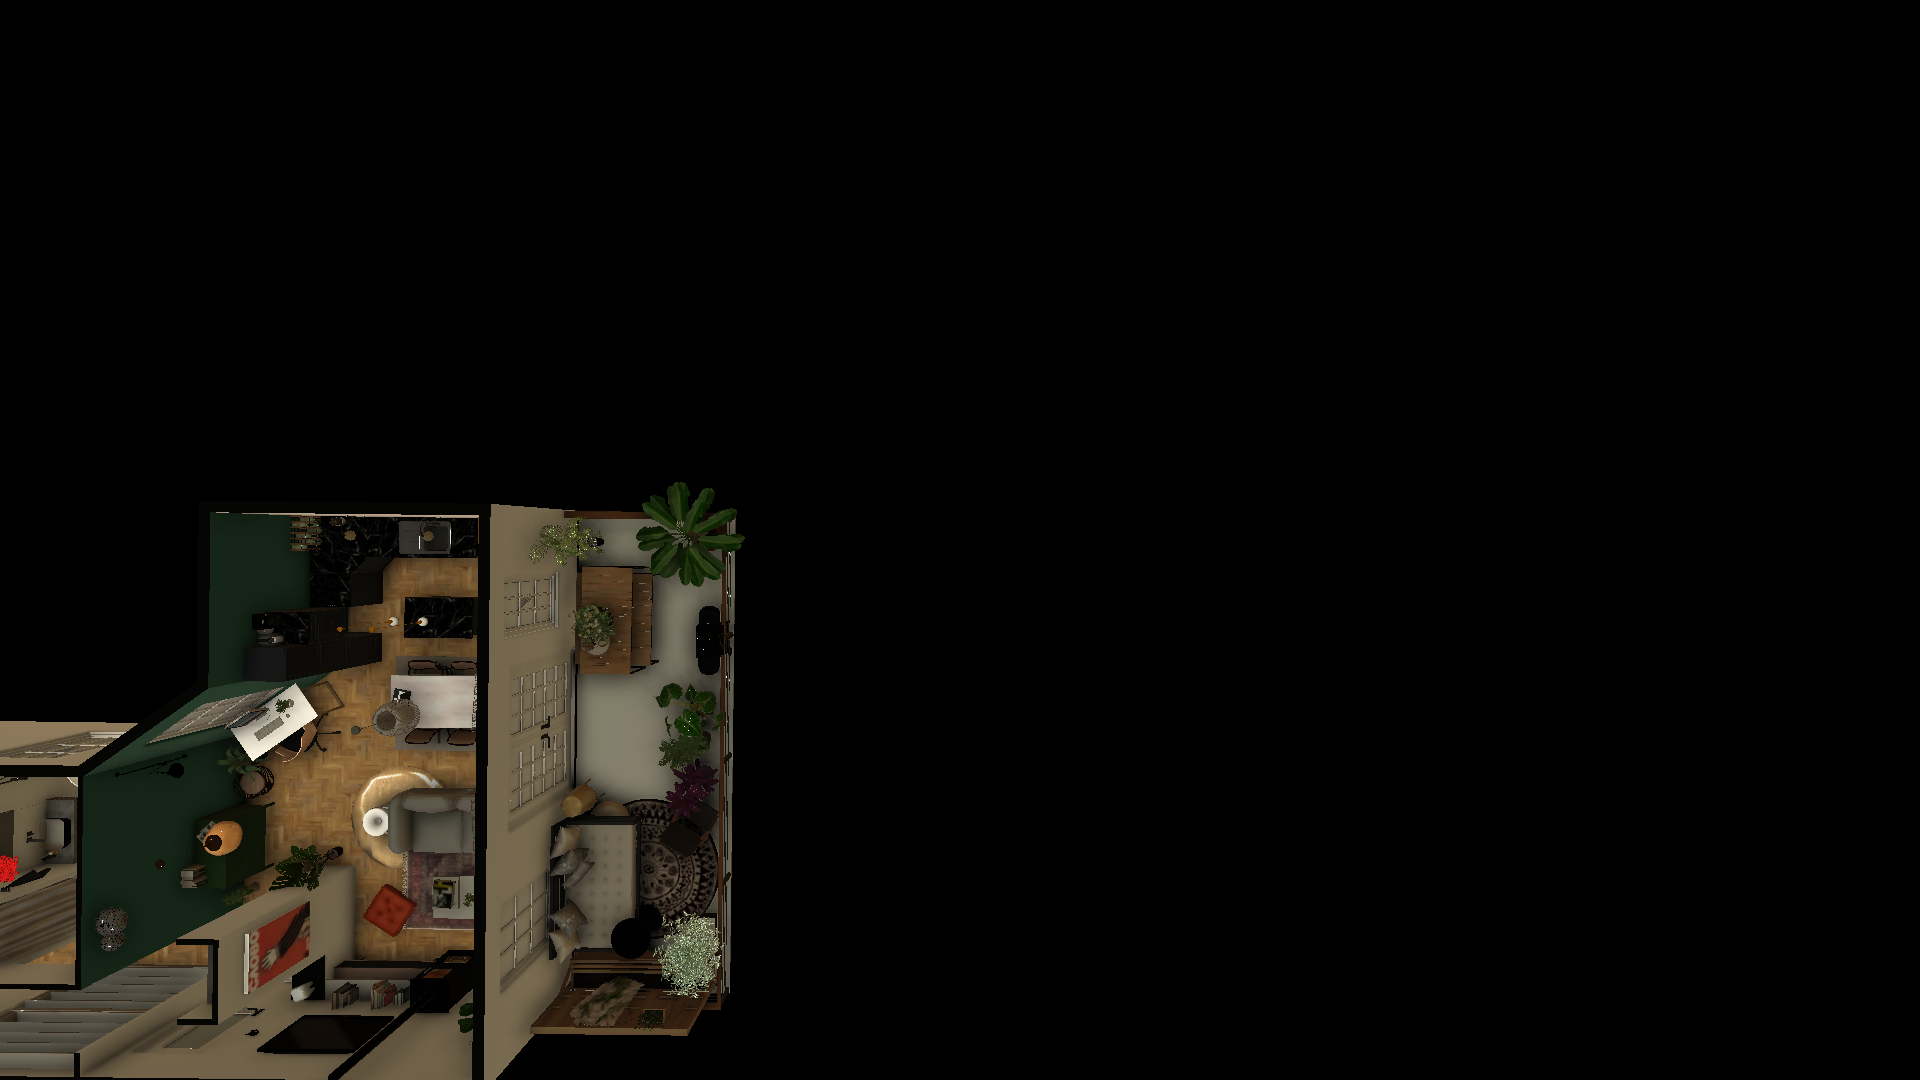

In [34]:
display_sample(obs['top_rgb'])

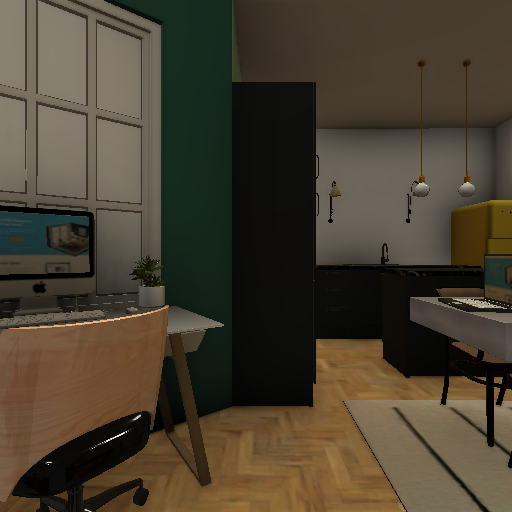

In [35]:
display_sample(env._sim.get_sensor_observations()['rgb'][:, :, :3])

In [36]:
import habitat_sim
def recompute_navmesh(sim):
    # recompute the NavMesh with STATIC objects
    navmesh_settings = habitat_sim.NavMeshSettings()
    navmesh_settings.set_defaults()
    navmesh_settings.include_static_objects = True
    navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)
    assert navmesh_success, "Failed to build static navmesh"
recompute_navmesh(env.sim) 

In [62]:
top_down_map.shape[1]

512

In [63]:
maps.from_grid(top_down_map.shape[0]//2, top_down_map.shape[1]//2, top_down_map.shape, env.sim)

(-4.079901960941026, -16.85724449157715)

In [96]:
obs = env.reset()

In [97]:
env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': np.array([-16.85724449157715, 0.12783068, -4.079901960941026]), 'angle_crd': np.array([0.0, 1.0, 0.0, 0.0])}})

{'rgb': array([[[ 21,  37,  24],
         [ 21,  37,  24],
         [ 21,  37,  24],
         ...,
         [128, 121, 105],
         [128, 121, 105],
         [128, 121, 105]],
 
        [[ 21,  37,  24],
         [ 21,  37,  24],
         [ 21,  37,  24],
         ...,
         [128, 121, 105],
         [128, 121, 105],
         [128, 121, 105]],
 
        [[ 21,  37,  24],
         [ 21,  37,  24],
         [ 21,  37,  24],
         ...,
         [128, 120, 105],
         [128, 120, 105],
         [128, 120, 105]],
 
        ...,
 
        [[ 16,  28,  17],
         [ 16,  29,  18],
         [ 10,   4,   1],
         ...,
         [124, 115,  96],
         [125, 115,  97],
         [124, 115,  97]],
 
        [[ 16,  29,  18],
         [133, 106,  84],
         [119,  94,  75],
         ...,
         [126, 117,  97],
         [126, 116,  97],
         [125, 117,  98]],
 
        [[147, 118,  94],
         [118,  91,  73],
         [106,  82,  64],
         ...,
         [127, 119, 1

In [106]:
obs = env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': np.array([-16.85724449157715, 0.12783068, -4.079901960941026]), 'angle_crd': np.array([0.0, 1.0, 0.0, 0.0])}})

In [111]:
img = display_sample(obs['top_rgb'])

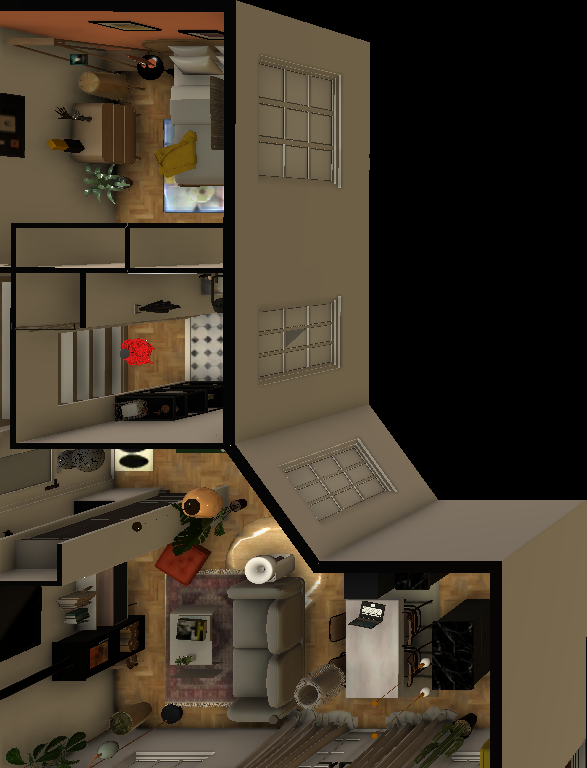

In [114]:
bbox = img.getbbox()
cropped_image = img.crop(bbox)
cropped_image

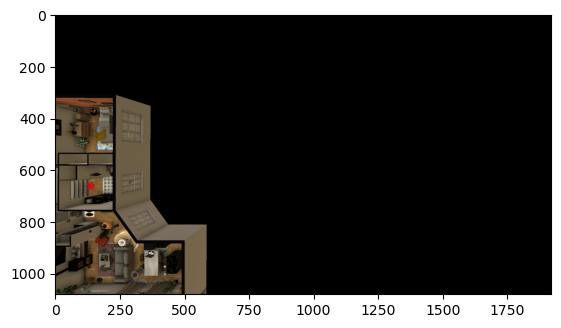

In [108]:
plt.imshow(display_sample(obs['top_rgb']))

In [66]:
env.sim.get_agent_state().position, 

(array([-15.95935   ,   0.12783068,  -4.68259   ], dtype=float32),
 quaternion(-0.212349995970726, 0, 0.977190017700195, 0))

In [76]:
obs = env.step('move_forward')
env.sim.get_agent_state().position, env.sim.get_agent_state().rotation

(array([-15.744677  ,   0.12783068,  -4.211977  ], dtype=float32),
 quaternion(-0.672497928142548, 0, 0.740099012851715, 0))

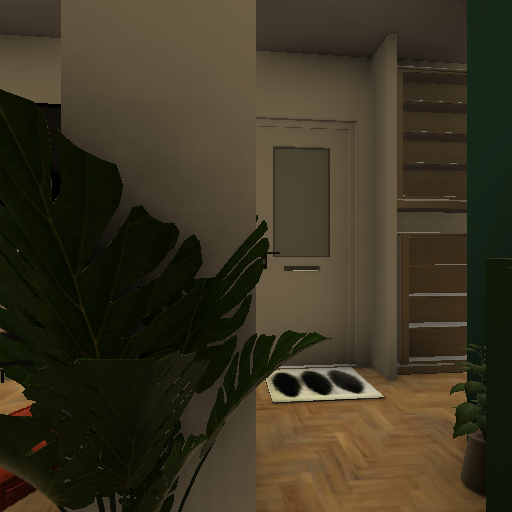

In [77]:
display_sample(obs['rgb'])

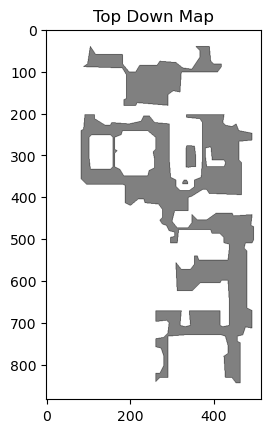

In [59]:
from habitat.utils.visualizations import maps
top_down_map = maps.get_topdown_map_from_sim(env.sim, map_resolution=512)
recolor_map = np.array(
                [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
            )
top_down_map = recolor_map[top_down_map]
plt.imshow(top_down_map)
plt.title("Top Down Map")
plt.show()

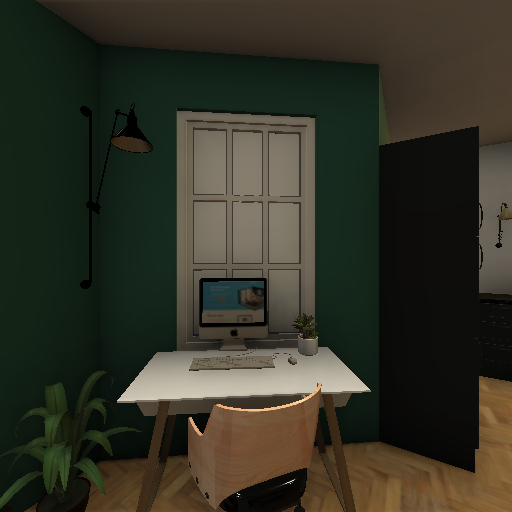

In [38]:
num = 1
actions = ['move_forward', 'turn_left', 'turn_right']
action = actions[1]
for i in range(num):
    obs = env.step(action)
display_sample(obs['third_rgb'])

In [39]:
env.sim.get_agent_state().position, env.sim.get_agent_state().rotation

(array([-15.95935   ,   0.12783068,  -4.68259   ], dtype=float32),
 quaternion(0.494951665401459, 0, 0.868920564651489, 0))

In [40]:
env.sim.set_agent_state(env.sim.get_agent_state().position, env.sim.get_agent_state().rotation)

True

In [55]:
env.reset()

{'rgb': array([[[ 72,  60,  48],
         [ 72,  60,  48],
         [ 72,  60,  48],
         ...,
         [ 62,  53,  41],
         [ 62,  53,  41],
         [ 63,  53,  41]],
 
        [[ 72,  61,  48],
         [ 72,  61,  48],
         [ 72,  61,  48],
         ...,
         [ 59,  50,  39],
         [ 59,  50,  39],
         [ 60,  50,  39]],
 
        [[ 72,  61,  48],
         [ 72,  61,  48],
         [ 72,  61,  48],
         ...,
         [ 57,  47,  37],
         [ 57,  47,  37],
         [ 57,  47,  37]],
 
        ...,
 
        [[ 98,  71,  43],
         [ 97,  70,  42],
         [ 96,  69,  41],
         ...,
         [172, 157, 144],
         [172, 157, 144],
         [172, 157, 144]],
 
        [[103,  74,  45],
         [102,  73,  44],
         [103,  74,  45],
         ...,
         [172, 157, 144],
         [172, 157, 144],
         [172, 157, 144]],
 
        [[110,  78,  49],
         [110,  78,  49],
         [108,  77,  48],
         ...,
         [172, 157, 1

In [56]:
obs = env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': np.array([-15.95935, 0.12783068, -4.68259]), 'angle_crd': env.sim.get_agent_state().rotation}})

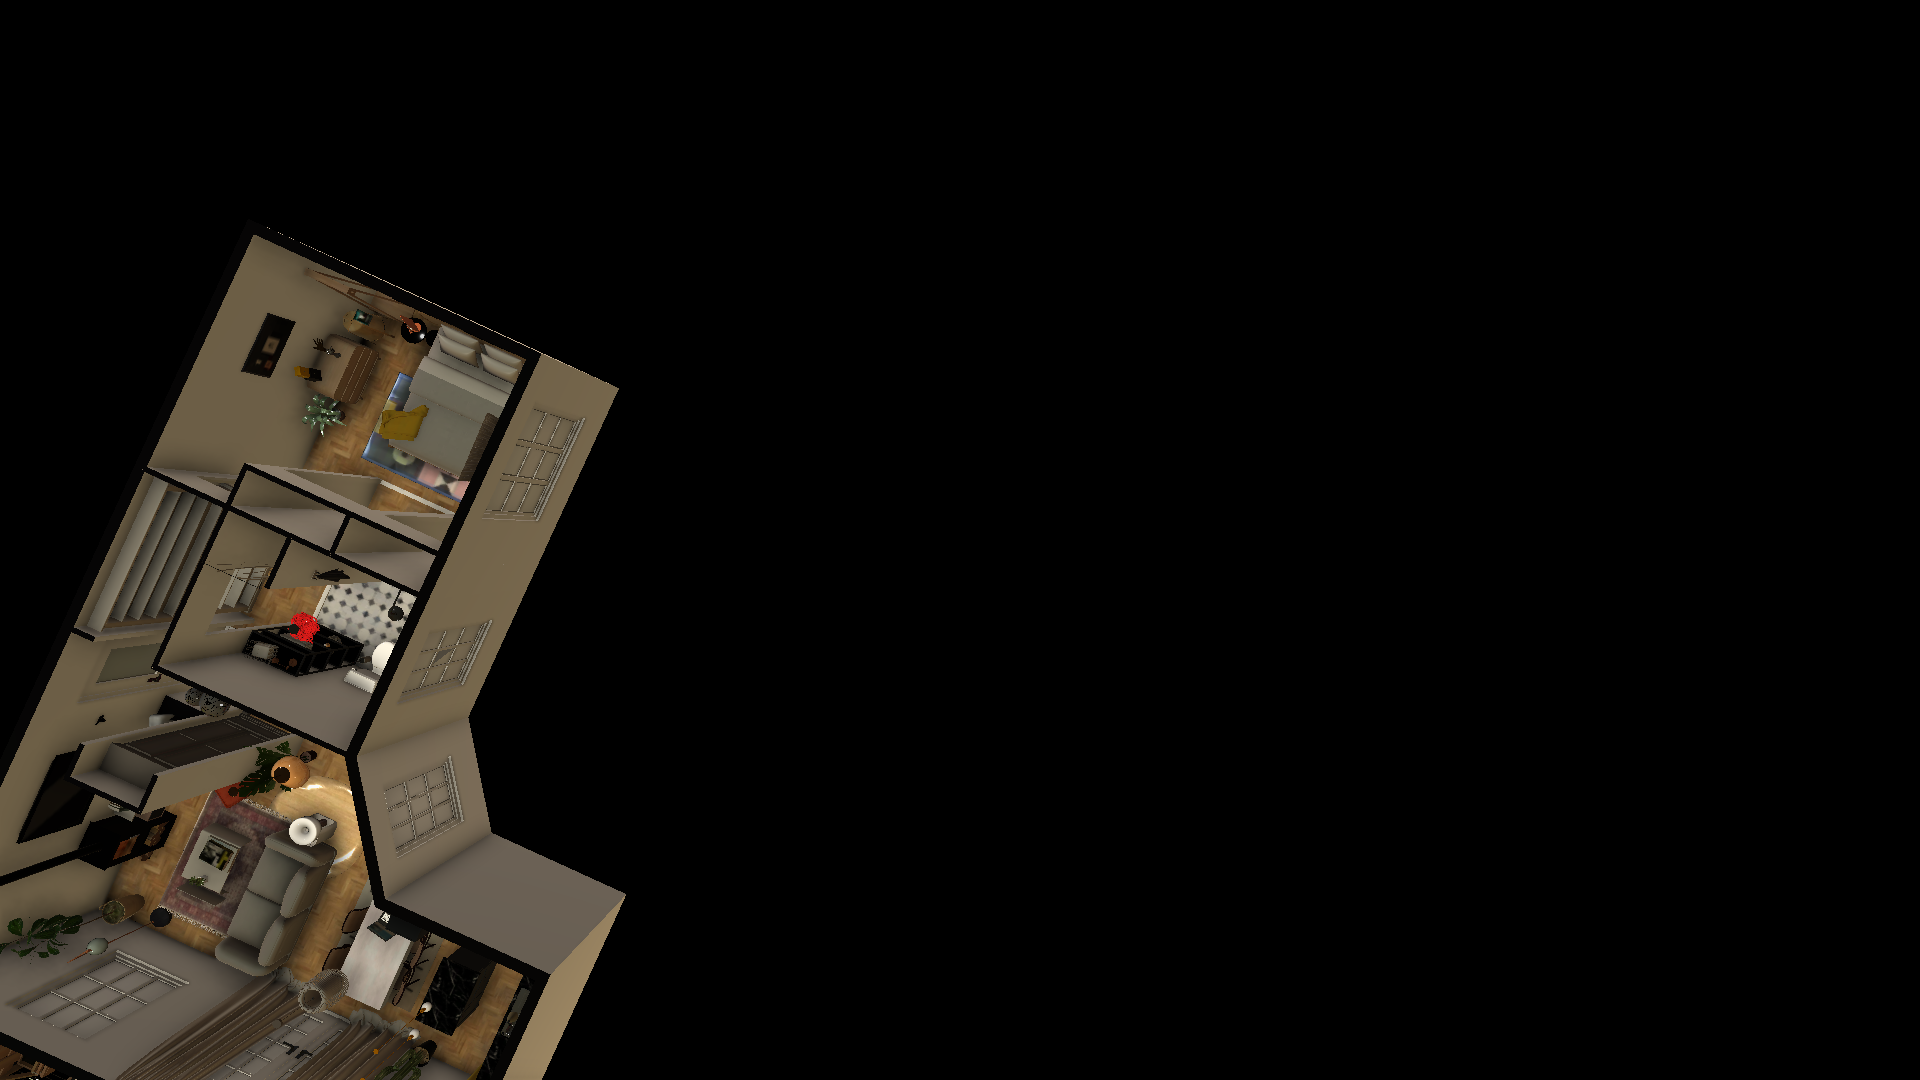

In [57]:
display_sample(obs['top_rgb'])

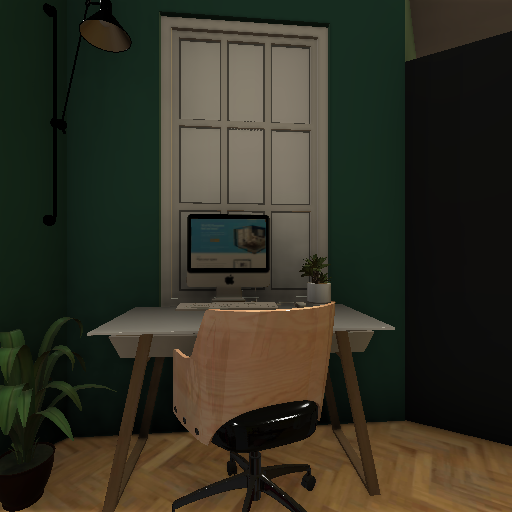

In [41]:
display_sample(env.sim.get_sensor_observations()['rgb'][:, :, :3])

In [19]:
obs = env.step('move_forward')

In [20]:
display_sample(obs['third_rgb'])

In [21]:
env.step({"action":"param_change_loc", "action_args": {"pos_crd": np.array([-16.06258,   0.13964,  -5.05769]), "angle_crd": np.array([-0.978479981422424, 0, 0.206359997391701, 0])}})

{'rgb': array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[20, 22,  6],
         [25, 35, 15],
         [27, 37, 16],
         ...,
         [95, 82, 61],
         [97, 84, 63],
         [99, 86, 64]],
 
        [[19, 21,  6],
         [26, 36, 16],
         [27, 37, 16],
         ...,
         [95, 83, 61],
         [97, 84, 63],
         [99, 86, 64]],
 
        [[20, 21,  7],
         [27, 37, 16],
         [28, 38, 17],
         ...,
         [95, 83, 61],
         [97, 84, 63],
         [99, 86, 64]]], dtype=uint8),
 'depth': array([[[0.        ],
   

In [38]:
obs = env.step({"action":"param_change_loc", "action_args": {"pos_crd": np.array([-16.06258,   0.13964,  -5.05769]), "angle_crd": np.array([-0.978479981422424, 0, 0.206359997391701, 0])}})

In [40]:
obs = env.step('move_forward')
obs

{'rgb': array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[ 11,  11,   3],
         [ 10,  10,   3],
         [ 10,  10,   3],
         ...,
         [107,  93,  69],
         [107,  93,  69],
         [107,  93,  69]],
 
        [[ 10,  10,   3],
         [ 10,  10,   3],
         [ 10,  10,   3],
         ...,
         [107,  93,  69],
         [107,  93,  69],
         [107,  93,  69]],
 
        [[ 11,  11,   4],
         [ 10,  10,   3],
         [  9,   9,   3],
         ...,
         [107,  93,  

In [37]:
obs = env.reset()
env.sim.get_agent_state().position, env.sim.get_agent_state().rotation

(array([-16.06258,   0.13964,  -5.05769], dtype=float32),
 quaternion(-0.978479981422424, 0, 0.206359997391701, 0))

In [158]:
obs = env.step('move_forward') 

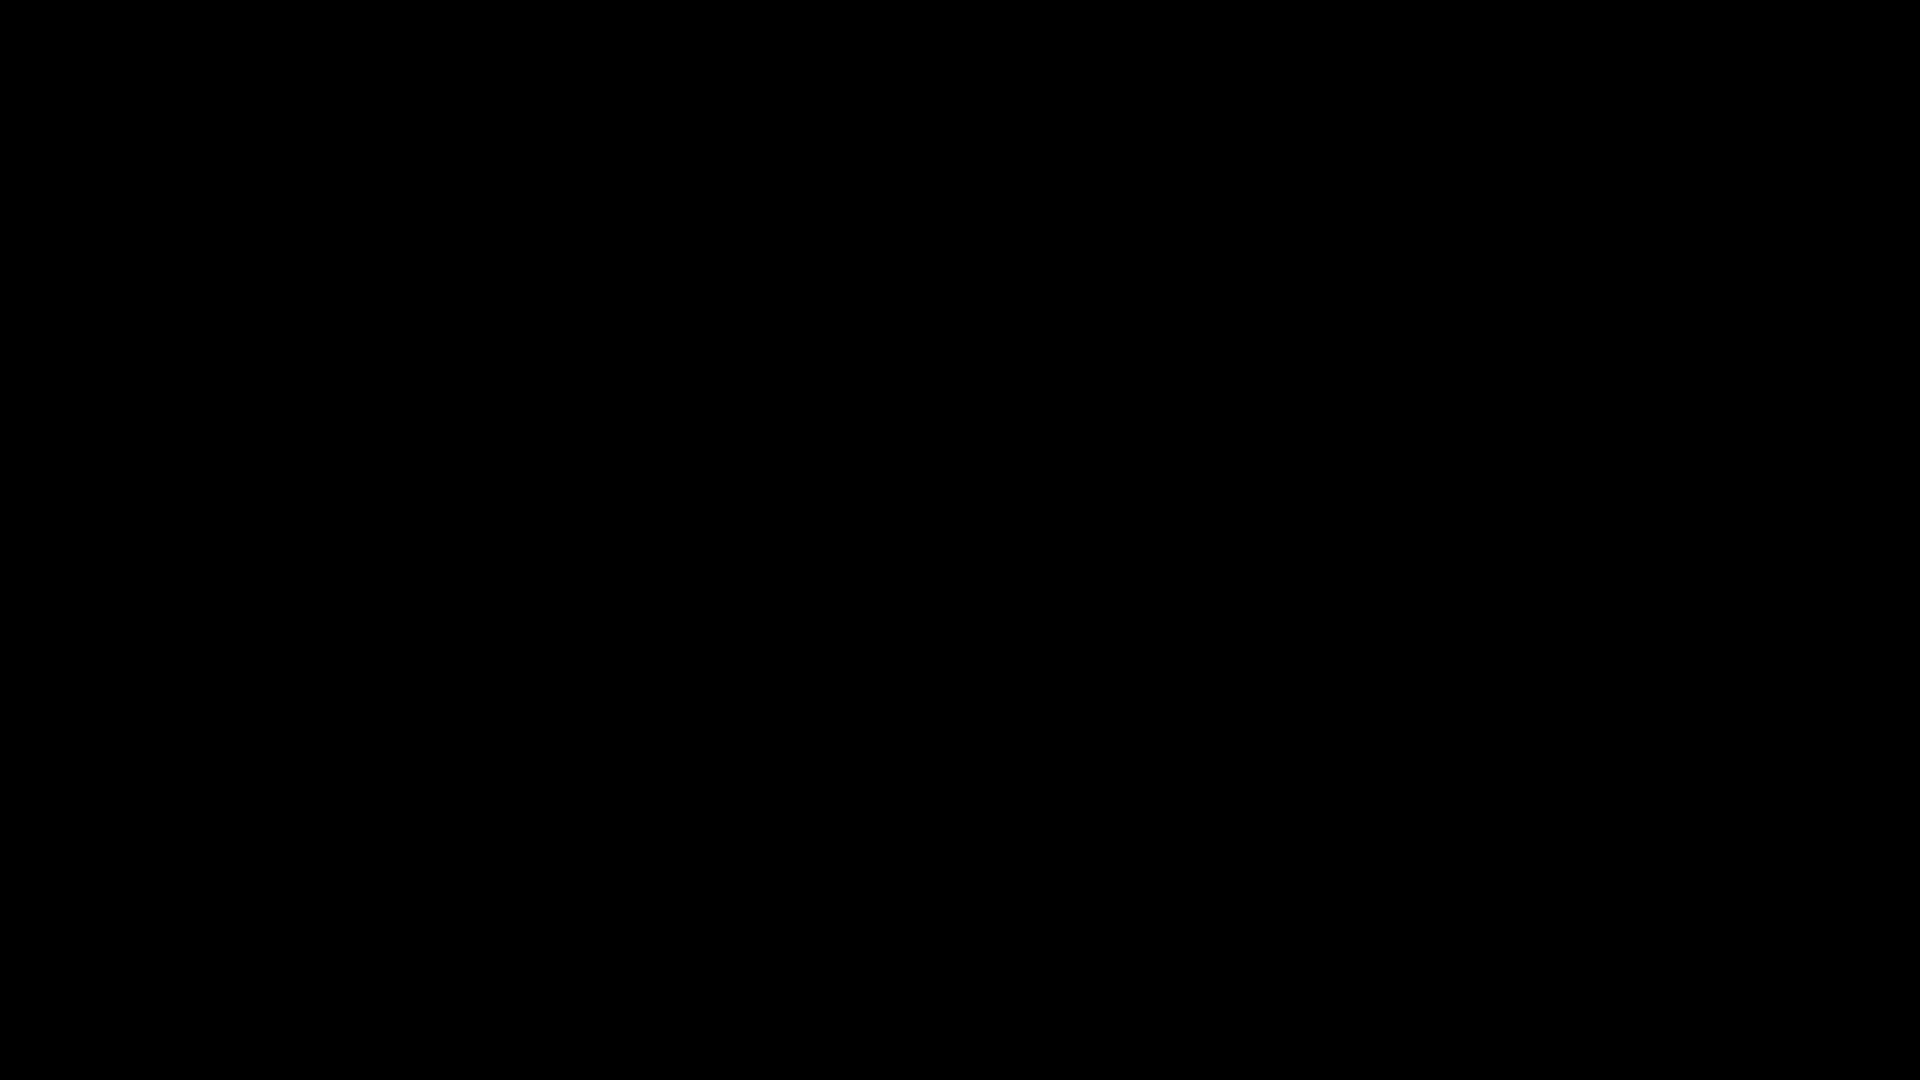

In [159]:
display_sample(obs['top_rgb'])

In [ ]:
9.5, 15.0

In [133]:
env.sim.get_agent_state().rotation

quaternion(-0.50503134727478, 0, 0.863101065158844, 0)

In [52]:
env.sim.get_agent_state()

AgentState(position=array([-14.147715,   0.2     ,  -3.598021], dtype=float32), rotation=quaternion(-0.711209774017334, 0, 0.702979862689972, 0), sensor_states={'head_rgb': SixDOFPose(position=array([-14.147715,   1.45    ,  -3.598021], dtype=float32), rotation=quaternion(-0.711209774017334, 0, 0.702979862689972, 0)), 'head_depth': SixDOFPose(position=array([-14.147715,   1.45    ,  -3.598021], dtype=float32), rotation=quaternion(-0.711209774017334, 0, 0.702979862689972, 0)), 'third_rgb': SixDOFPose(position=array([-14.147715,   1.45    ,  -3.598021], dtype=float32), rotation=quaternion(-0.711209774017334, 0, 0.702979862689972, 0)), 'top_rgb': SixDOFPose(position=array([-10.037418 ,  15.2      ,   5.8547816], dtype=float32), rotation=quaternion(-0.503101408481598, 0.502700984477997, 0.497279673814774, 0.496883869171143))})

In [7]:
import json
from omegaconf import OmegaConf
print(json.dumps(OmegaConf.to_container(config), indent=4))

{
    "habitat_baselines": {
        "evaluate": false,
        "trainer_name": "ver",
        "updater_name": "PPO",
        "distrib_updater_name": "DDPPO",
        "torch_gpu_id": 0,
        "tensorboard_dir": "data/training/objectnav/hssd-hab/tb",
        "writer_type": "tb",
        "video_dir": "data/training/objectnav/hssd-hab/video_dir",
        "video_fps": 10,
        "test_episode_count": -1,
        "eval_ckpt_path_dir": "data/training/objectnav/hssd-hab/checkpoints/",
        "num_environments": 24,
        "num_processes": -1,
        "rollout_storage_name": "RolloutStorage",
        "checkpoint_folder": "data/training/objectnav/hssd-hab/checkpoints",
        "num_updates": 270000,
        "num_checkpoints": 500,
        "checkpoint_interval": -1,
        "total_num_steps": -1.0,
        "log_interval": 10,
        "log_file": "train.log",
        "force_blind_policy": false,
        "verbose": true,
        "vector_env_factory": {
            "_target_": "habitat_baselin

In [3]:
env = habitat.Env(config=config)
print(env._episode_from_iter_on_reset)

2024-05-27 09:07:52,698 Initializing dataset ObjectNav-v1
2024-05-27 09:08:04,643 initializing sim Sim-v0
2024-05-27 09:08:06,961 Initializing task ObjectNav-v1


Renderer:False
 NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.129.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


[09:08:06:100242]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hssd-hab' : Lighting Layout Attributes 'data/scene_datasets/hssd-hab/scenes/104348394_171513453.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[09:08:06:162032]:[Warning]:[Sim] Simulator.cpp(594)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


In [8]:
env.get_metrics()

{'distance_to_goal': 4.066612720489502,
 'success': 0.0,
 'spl': 0.0,
 'soft_spl': 0.0,
 'distance_to_goal_reward': -0.0}

In [6]:
env._episode_from_iter_on_reset = False

In [7]:
env.episode_iterator._forced_scene_switch()


In [8]:
env.reset() 
env._current_episode

ObjectGoalNavEpisode(episode_id='628', scene_id='data/scene_datasets/hssd-hab/scenes/104348394_171513453', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-15.95935, 0.13964, -4.68259], start_rotation=[0, 0.71121, 0, 0.70298], info={'geodesic_distance': 3.85302, 'euclidean_distance': 2.88609, 'closest_goal_object_id': 118}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fe262d6a4b0>, goals=[ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39

In [9]:
env.episode_iterator._forced_scene_switch

<bound method EpisodeIterator._forced_scene_switch of <habitat.core.dataset.EpisodeIterator object at 0x7fe59f46b8e0>>

In [10]:
dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset, 
    )

2024-05-27 08:24:28,917 Initializing dataset ObjectNav-v1


In [35]:
config.habitat.dataset.type

'ObjectNav-v1'

In [36]:
env = habitat.Env(config=config, dataset=dataset)

2024-05-24 22:57:49,450 initializing sim Sim-v0
2024-05-24 22:57:55,246 Initializing task ObjectNav-v1


In [37]:
env.reset()
env._current_episode


ObjectGoalNavEpisode(episode_id='628', scene_id='data/scene_datasets/hssd-hab/scenes/104348394_171513453', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-15.95935, 0.13964, -4.68259], start_rotation=[0, 0.71121, 0, 0.70298], info={'geodesic_distance': 3.85302, 'euclidean_distance': 2.88609, 'closest_goal_object_id': 118}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7f8689cde830>, goals=[ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39

In [38]:
env._episode_force_changed = True

In [39]:
env._episode_iterator._forced_scene_switch()
env.reset()

{'rgb': array([[[71, 60, 47],
         [71, 60, 47],
         [71, 60, 47],
         ...,
         [71, 59, 46],
         [71, 59, 46],
         [71, 59, 46]],
 
        [[71, 60, 47],
         [71, 60, 47],
         [71, 60, 47],
         ...,
         [71, 59, 46],
         [71, 59, 46],
         [71, 60, 46]],
 
        [[71, 60, 47],
         [71, 60, 47],
         [71, 60, 47],
         ...,
         [71, 60, 46],
         [71, 60, 46],
         [71, 60, 46]],
 
        ...,
 
        [[20, 29, 35],
         [20, 29, 35],
         [20, 29, 35],
         ...,
         [20, 30, 35],
         [20, 30, 35],
         [20, 31, 35]],
 
        [[20, 29, 35],
         [20, 29, 35],
         [20, 29, 35],
         ...,
         [20, 30, 35],
         [20, 30, 35],
         [20, 31, 35]],
 
        [[20, 30, 35],
         [20, 30, 35],
         [20, 30, 35],
         ...,
         [20, 30, 35],
         [20, 30, 35],
         [20, 30, 35]]], dtype=uint8),
 'depth': array([[[0.35553396],
   

In [43]:
i = 0
for ep in env._episode_iterator:
    print(ep)
    i += 1
    if i > 5:
        break

ObjectGoalNavEpisode(episode_id='666', scene_id='data/scene_datasets/hssd-hab/scenes/102344049', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[4.31273, 0.19575, -15.01165], start_rotation=[0, 0.41703, 0, -0.90889], info={'geodesic_distance': 16.93446, 'euclidean_distance': 15.45499, 'closest_goal_object_id': 37}, _shortest_path_cache=None, goals=[ObjectGoal(position=[-8.40875, 0.40023, -2.98129], radius=None, object_id=36, object_name='aa85073bb8fbfc43763bd0a117f6f6a03dca7bb9_:0000', object_name_id=None, object_category='couch', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-7.60618, 0.19575, -2.98258], rotation=[0.0, 0.70768, 0.0, 0.70654]), iou=1.03132), ObjectViewLocation(agent_state=AgentState(position=[-7.60618, 0.19575, -2.89258], rotation=[0.0, 0.66714, 0.0, 0.74494]), iou=1.0118), ObjectViewLocation(agent_state=AgentState(position=[-7.69618,

In [45]:
for ep in env._episode_iterator:
    env.current_episode = ep

In [63]:
env.episode_iterator._forced_scene_switch
env._current_episode


ObjectGoalNavEpisode(episode_id='329', scene_id='data/scene_datasets/hssd-hab/scenes/103997562_171030642', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-14.9968, 0.19511, -8.5614], start_rotation=[0, 0.8292, 0, 0.55895], info={'geodesic_distance': 5.42128, 'euclidean_distance': 4.00792, 'closest_goal_object_id': 96}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7f1bb8af44b0>, goals=[ObjectGoal(position=[-13.89276, 1.50804, -13.94908], radius=None, object_id=96, object_name='0d6acbc9f35c8834a605e284167f44c84582a975_:0000', object_name_id=None, object_category='tv', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-13.4883, 0.19511, -13.95704], rotation=[0.0, 0.71403, 0.0, 0.70012]), iou=2.23124), ObjectViewLocation(agent_state=AgentState(position=[-13.4883, 0.19511, -13.86704], rotation=[0.0, 0.63293, 0.

In [7]:
env.reset()
env._current_episode

NameError: name 'env' is not defined

In [65]:
# Use: env.episode_iterator._forced_scene_switch, for switching your episodes
# I know how to switch scenes, now towards object mapping and path planning
# Next is to label topdownmap, what the hell is fog of war? Figure it out
# Then just compilation I guess
# Then diffuser

In [12]:
def showstateat(pos, orientation):
    obj = env.step({"action":("param_chl"), "action_args":{'pos_crd':np.array(pos), 'angle_crd':np.array(orientation)}})
    return display_sample(obj["rgb"])

In [13]:
# How to use pretrained model for navigation 

In [14]:
# We have model architecture and corresponding weights
# Now initialize this model and generate data
#
# How to get data, sort this out tonight

In [15]:
import gzip
import json

with gzip.open('/data/reventh/habitat-lab/data/datasets/objectnav/hssd-hab/train/train.json.gz', 'rt') as f:
    data = json.load(f)

In [7]:
data

{'episodes': [],
 'category_to_task_category_id': {'chair': 0,
  'bed': 1,
  'potted_plant': 2,
  'toilet': 3,
  'tv': 4,
  'couch': 5},
 'category_to_scene_annotation_category_id': {'chair': 0,
  'bed': 1,
  'potted_plant': 2,
  'toilet': 3,
  'tv': 4,
  'couch': 5}}

In [8]:
with gzip.open('/data/reventh/habitat-lab/data/datasets/objectnav/hssd-hab/train/content/104348394_171513453.json.gz', 'rt') as f:
    data_tr = json.load(f)

In [72]:
data_tr.keys()

dict_keys(['goals_by_category', 'episodes', 'category_to_task_category_id', 'category_to_scene_annotation_category_id'])

In [73]:
cats = data_tr['goals_by_category'].keys()
cats = [x.split('_')[-1] for x in cats]

In [74]:
othercats = set([x['object_category'] for x in data_tr['episodes']])
othercats

{'bed', 'chair', 'couch', 'potted_plant', 'toilet', 'tv'}

In [75]:
data_tr['episodes']

[{'episode_id': '0',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-13.85135, 0.13964, 0.7013],
  'start_rotation': [0, 0.58106, 0, -0.81386],
  'info': {'geodesic_distance': 5.59535,
   'euclidean_distance': 4.75446,
   'closest_goal_object_id': 8},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'chair'},
 {'episode_id': '1',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-13.86376, 0.13964, 0.7711],
  'start_rotation': [0, 0.30379, 0, 0.95274],
  'info': {'geodesic_distance': 5.66327,
   'euclidean_distance': 4.81481,
   'closest_goal_object_id': 8},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'chair'},
 {'episode_id': '2',
  'sce

In [76]:
data_tr['goals_by_category']['104348394_171513453_tv']

[{'position': [-13.08936, 1.75, -5.41226],
  'radius': None,
  'object_id': 33,
  'object_name': '8a643866e25ff2687ae34a7285e1927fed1205d3_:0000',
  'object_name_id': None,
  'object_category': 'tv',
  'room_id': None,
  'room_name': None,
  'view_points': [{'agent_state': {'position': [-13.67734, 0.13964, -5.43799],
     'rotation': [0.0, -0.7224, 0.0, 0.69148]},
    'iou': 0.63171},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.34799],
     'rotation': [0.0, -0.66759, 0.0, 0.74453]},
    'iou': 0.62794},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.52799],
     'rotation': [0.0, -0.77237, 0.0, 0.63517]},
    'iou': 0.61148},
   {'agent_state': {'position': [-13.76734, 0.13964, -5.43799],
     'rotation': [0.0, -0.72039, 0.0, 0.69357]},
    'iou': 0.60729},
   {'agent_state': {'position': [-13.76734, 0.13964, -5.34799],
     'rotation': [0.0, -0.67291, 0.0, 0.73972]},
    'iou': 0.6015},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.25799],
     'rotatio

In [77]:
# I guess the goals by category is essentially valid final positions for the agent
# And the episodes have agent's initial position and orientation

In [78]:
# Get what are the goals in your data?


In [79]:
sorted([x for x in data_tr['episodes'] if x['object_category']=='tv'], key=lambda x: (x['start_position'], x['start_rotation']))

[{'episode_id': '771',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-19.43811, 0.13964, -7.04298],
  'start_rotation': [0, 0.73894, 0, -0.67377],
  'info': {'geodesic_distance': 7.49635,
   'euclidean_distance': 6.63774,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '690',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-19.41502, 0.13964, -6.96088],
  'start_rotation': [0, 0.92659, 0, 0.37606],
  'info': {'geodesic_distance': 7.41314,
   'euclidean_distance': 6.5789,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '802',
 

In [80]:
# Be sure to set these 2 configs: "habitat.environment.iterator_options.num_episode_sample=1",
            # "habitat.environment.iterator_options.shuffle=False" which prevents shuffling of episodes across config

In [3]:
import os
from loguru import logger

import git

import habitat

# # Set paths
# repo = git.Repo(".", search_parent_directories=True)
# dir_path = repo.working_tree_dir
# data_path = os.path.join(dir_path, "data")
# os.chdir(dir_path)
logger.info(f"Inside initialize_env.py: Current working directory: {os.getcwd()}")

import sys
sys.path.append(os.getcwd())
# Add parametrized actions to the config
from examples.random_walk_sim.parametrized_action import add_param_actions

def define_config():
    # Config for HSSD Dataset and DDPPO model with pretrained weights (we don't use this model for now)
    dir_path = os.getcwd()
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat_baselines.eval.split=train",
            # "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            # "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            # "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat.simulator.habitat_sim_v0.enable_physics=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false",
            "habitat.environment.iterator_options.num_episode_sample=1",
            "habitat.environment.iterator_options.shuffle=False"
        ],
    )
    config = add_param_actions(config)
    return config

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()
    
def create_env(dataset=None):
    config = define_config()
    if dataset is not None:
        env = SimpleRLEnv(config=config, dataset=dataset)
    else:
        env = SimpleRLEnv(config=config)
    return env

2024-05-27 08:45:10.104 | INFO     | __main__:<module>:13 - Inside initialize_env.py: Current working directory: /data/reventh/habitat-lab


In [4]:
import json
from omegaconf import OmegaConf
print(json.dumps(OmegaConf.to_container(define_config()), indent=4))

MissingConfigException: In 'benchmark/nav/objectnav/hssd-200_objectnav_hssd-hab': Could not find 'habitat/simulator/sim_sensors/rgbd'

Available options in 'habitat/simulator/sim_sensors':
	arm_depth_sensor
	arm_panoptic_sensor
	arm_rgb_sensor
	depth_sensor
	equirect_depth_sensor
	equirect_rgb_sensor
	equirect_semantic_sensor
	head_depth_sensor
	head_panoptic_sensor
	head_rgb_sensor
	head_stereo_left_depth_sensor
	head_stereo_right_depth_sensor
	jaw_depth_sensor
	jaw_panoptic_sensor
	jaw_rgb_sensor
	rgb_sensor
	semantic_sensor
	third_depth_sensor
	third_rgb_sensor
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///data/reventh/habitat-lab/habitat-baselines/habitat_baselines/config/objectnav
	provider=habitat, path=pkg://habitat.config
	provider=schema, path=structured://

In [8]:
env = create_env(dataset=dataset)
obs = env.reset()
default_spawn = env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation

2024-05-27 03:42:16,160 initializing sim Sim-v0
[03:42:17:613884]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hssd-hab' : Lighting Layout Attributes 'data/scene_datasets/hssd-hab/scenes/103997562_171030642.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
2024-05-27 03:42:18,881 Initializing task ObjectNav-v1
[03:42:17:730972]:[Warning]:[Sim] Simulator.cpp(594)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


In [17]:
env.habitat_env.sim.agents[0].agent_config.sensor_specifications[0]

AttributeError: 'habitat_sim._ext.habitat_sim_bindings.CameraSensor' object has no attribute 'height'

In [23]:
env.habitat_env.sim.get_agent()

TypeError: get_agent() missing 1 required positional argument: 'agent_id'

In [83]:
goal = env.habitat_env.current_episode.goals[0]

In [84]:
env.habitat_env.current_episode

ObjectGoalNavEpisode(episode_id='329', scene_id='data/scene_datasets/hssd-hab/scenes/103997562_171030642', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-14.9968, 0.19511, -8.5614], start_rotation=[0, 0.8292, 0, 0.55895], info={'geodesic_distance': 5.42128, 'euclidean_distance': 4.00792, 'closest_goal_object_id': 96}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7f1b799ea3b0>, goals=[ObjectGoal(position=[-13.89276, 1.50804, -13.94908], radius=None, object_id=96, object_name='0d6acbc9f35c8834a605e284167f44c84582a975_:0000', object_name_id=None, object_category='tv', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-13.4883, 0.19511, -13.95704], rotation=[0.0, 0.71403, 0.0, 0.70012]), iou=2.23124), ObjectViewLocation(agent_state=AgentState(position=[-13.4883, 0.19511, -13.86704], rotation=[0.0, 0.63293, 0.

In [85]:
env.habitat_env.sim.get_agent_state()

AgentState(position=array([-14.9968 ,   0.19511,  -8.5614 ], dtype=float32), rotation=quaternion(0.558950006961823, 0, 0.829200029373169, 0), sensor_states={'rgb': SixDOFPose(position=array([-14.9968 ,   1.07511,  -8.5614 ], dtype=float32), rotation=quaternion(0.558950006961823, 0, 0.829200029373169, 0)), 'depth': SixDOFPose(position=array([-14.9968 ,   1.07511,  -8.5614 ], dtype=float32), rotation=quaternion(0.558950006961823, 0, 0.829200029373169, 0))})

In [86]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower


In [87]:
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = 0.25

In [88]:
follower = ShortestPathFollower(
        env.habitat_env.sim, goal_radius, False
    )

In [89]:
os.getcwd()

'/data/reventh/habitat-lab'

In [90]:
import sys
sys.path.append(os.getcwd()+'/examples/data_creation/')
from add_objects import recompute_navmesh, add_object, remove_object
recompute_navmesh(env.habitat_env.sim)

2024-05-24 22:24:25.028 | INFO     | add_objects:<module>:5 - Inside add_object.py: Current working directory: /data/reventh/habitat-lab


In [91]:
from topdownmap import draw_top_down_map, add_path_to_map


2024-05-24 22:24:26.472 | INFO     | topdownmap:<module>:7 - Inside topdownmap.py: Current working directory: /data/reventh/habitat-lab


In [92]:
os.makedirs('examples/data_creation/maps/tests/', exist_ok=True)
draw_top_down_map(env, 'examples/data_creation/maps/tests/ex1.png')

PermissionError: [Errno 13] Permission denied: '/data/reventh/habitat-lab/examples/data_creation/maps/tests/ex1.png'

<Figure size 640x480 with 0 Axes>

In [105]:
print(env.habitat_env.sim.get_agent_state())
print(env.habitat_env.current_episode)

AgentState(position=array([-15.95935,   0.13964,  -4.68259], dtype=float32), rotation=quaternion(0.702979981899261, 0, 0.711210012435913, 0), sensor_states={'rgb': SixDOFPose(position=array([-15.95935,   1.01964,  -4.68259], dtype=float32), rotation=quaternion(0.702979981899261, 0, 0.711210012435913, 0)), 'depth': SixDOFPose(position=array([-15.95935,   1.01964,  -4.68259], dtype=float32), rotation=quaternion(0.702979981899261, 0, 0.711210012435913, 0))})
ObjectGoalNavEpisode(episode_id='628', scene_id='data/scene_datasets/hssd-hab/scenes/104348394_171513453', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-15.95935, 0.13964, -4.68259], start_rotation=[0, 0.71121, 0, 0.70298], info={'geodesic_distance': 3.85302, 'euclidean_distance': 2.88609, 'closest_goal_object_id': 118}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fa0ac24bdb0>, goals=[ObjectGoal

In [106]:
path = []

In [107]:
env.step({"action":"param_change_loc", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})

while not env.habitat_env.episode_over:
    best_action = follower.get_next_action(
        goal.view_points[0].agent_state.position

    )
    if best_action is None:
        break
    observations, reward, done, info = env.step(best_action)
    im = observations["rgb"]
    path.append((env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation))
    # print(info)

In [108]:
path

[(array([-15.95935   ,   0.12783068,  -4.68259   ], dtype=float32),
  quaternion(0.494951665401459, 0, 0.868920564651489, 0)),
 (array([-15.95935   ,   0.12783068,  -4.68259   ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.081821  ,   0.12783068,  -4.4646435 ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.081821  ,   0.12783068,  -4.4646435 ], dtype=float32),
  quaternion(-0.00581955956295133, 0, 0.999983072280884, 0)),
 (array([-16.07891   ,   0.12783068,  -4.2146606 ], dtype=float32),
  quaternion(-0.00581955956295133, 0, 0.999983072280884, 0)),
 (array([-16.07891   ,   0.12783068,  -4.2146606 ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.201382  ,   0.12783068,  -3.996714  ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.201382  ,   0.12783068,  -3.996714  ], dtype=float32),
  quaternion(-0.00581955956295133, 0,

In [109]:
goal

ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39045, 0.0, 0.92062]), iou=0.28302), ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.12363], rotation=[0.0, 0.43885, 0.0, 0.89856]), iou=0.26681), ObjectViewLocation(agent_state=AgentState(position=[-15.36479, 0.13964, -2.03363], rotation=[0.0, 0.27718, 0.0, 0.96082]), iou=0.26309), ObjectViewLocation(agent_state=AgentState(position=[-15.09479, 0.13964, -2.21363], rotation=[0.0, 0.52889, 0.0, 0.84869]), iou=0.26212), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.03363], r

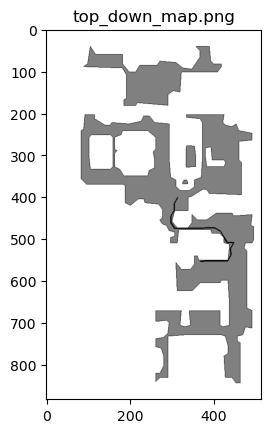

<Figure size 640x480 with 0 Axes>

In [110]:
add_path_to_map(path, env, image_save_path='examples/data_creation/maps/tests/exwtpath_noobstacle1.png')

In [111]:
path[random.randint(0, len(path))][0]

array([-16.07096   ,   0.12783068,  -3.5316942 ], dtype=float32)

In [112]:
obj_loc

array([15.169005  ,  0.07207882,  0.86317074], dtype=float32)

In [113]:
# obj_loc = path[random.randint(0, len(path))][0]
objid = add_object(env, obj_loc, scale=15.0, template_id=2) # Add cone
path_wt_obstacle = []
obs = env.reset()
env.step({"action":"param_change_loc", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})
while not env.habitat_env.episode_over:
    best_action = follower.get_next_action(
        goal.view_points[0].agent_state.position

    )
    if best_action is None:
        break
    observations, reward, done, info = env.step(best_action)
    im = observations["rgb"]
    path_wt_obstacle.append((env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation))
    # print(info)

In [114]:
path_wt_obstacle

[(array([-15.95935   ,   0.19707882,  -4.68259   ], dtype=float32),
  quaternion(0.494951665401459, 0, 0.868920564651489, 0)),
 (array([-15.95935   ,   0.19707882,  -4.68259   ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.081821  ,   0.19707882,  -4.4646435 ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.081821  ,   0.19707882,  -4.4646435 ], dtype=float32),
  quaternion(-0.00581955956295133, 0, 0.999983072280884, 0)),
 (array([-16.07891   ,   0.19707882,  -4.2146606 ], dtype=float32),
  quaternion(-0.00581955956295133, 0, 0.999983072280884, 0)),
 (array([-16.07891   ,   0.19707882,  -4.2146606 ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.201382  ,   0.19707882,  -3.996714  ], dtype=float32),
  quaternion(0.253193408250809, 0, 0.967415690422058, 0)),
 (array([-16.201382  ,   0.19707882,  -3.996714  ], dtype=float32),
  quaternion(-0.00581955956295133, 0,

In [115]:
goal

ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39045, 0.0, 0.92062]), iou=0.28302), ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.12363], rotation=[0.0, 0.43885, 0.0, 0.89856]), iou=0.26681), ObjectViewLocation(agent_state=AgentState(position=[-15.36479, 0.13964, -2.03363], rotation=[0.0, 0.27718, 0.0, 0.96082]), iou=0.26309), ObjectViewLocation(agent_state=AgentState(position=[-15.09479, 0.13964, -2.21363], rotation=[0.0, 0.52889, 0.0, 0.84869]), iou=0.26212), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.03363], r

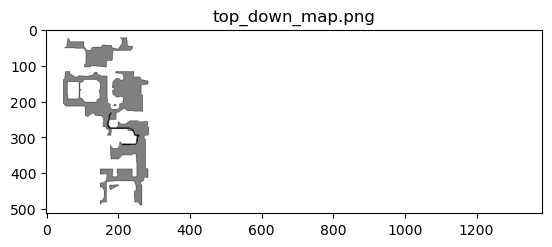

<Figure size 640x480 with 0 Axes>

In [116]:
add_path_to_map(path_wt_obstacle, env, image_save_path='examples/data_creation/maps/tests/exwtpath_noobstacle1.png')

In [117]:
remove_object(env, objid)

In [118]:
env.habitat_env.episode_over

True

In [127]:
env.reset()
print(env.habitat_env.current_episode)

ObjectGoalNavEpisode(episode_id='220', scene_id='data/scene_datasets/hssd-hab/scenes/104348394_171513453', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-16.65877, 0.13964, -6.61834], start_rotation=[0, 0.84484, 0, -0.53502], info={'geodesic_distance': 1.22059, 'euclidean_distance': 1.06118, 'closest_goal_object_id': 4}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fa0b8521eb0>, goals=[ObjectGoal(position=[-16.57146, 0.36, -3.23488], radius=None, object_id=132, object_name='09843c7d1af4d42f2c34c69e80992049361770dd_:0000', object_name_id=None, object_category='potted_plant', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-16.10516, 0.13964, -3.48614], rotation=[0.0, 0.85859, 0.0, 0.51266]), iou=0.12975), ObjectViewLocation(agent_state=AgentState(position=[-16.19516, 0.13964, -3.57614], rotation=[0.0, 0

In [ ]:
#_sim has somethign to do with sensor, tutorial at habitat_lab.py